In [1]:
#1 - Import libraries

import os
import tempfile
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from decimal import *

import pandas as pd

from datetime import datetime

import numpy as np


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Model


import keras.backend as K # type: ignore
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense,Dropout, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.layers.experimental import RandomFourierFeatures


from imblearn.over_sampling import SMOTE

from scipy import interp
from itertools import cycle


import dask.dataframe as dd

from sklearn.metrics import roc_auc_score

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


#2 - additional functions

def TSS_matrix_confusion(TN, FP, FN, TP):
    TSS = 0
    
    sensitivity = TP / (TP + FP)
    specificity = TN / (FN + TN)
    TSS = sensitivity + specificity - 1

    return TSS


def HSS_matrix_confusion(TN, FP, FN, TP):
    HSS = 0
    
    HSS = ( 2 * ((TP * TN) - (FN * FP)) ) / ( (TP + FN)* (FN + TN) + (TP + FN) * (FP + TN) )
    
    return HSS

def FAR_matrix_confusion(TN, FP, FN, TP):
    FAR = 0

    FAR = FP/(TP+FP)

    return FAR


def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)


def true_positive(y_true, y_pred):
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp


def true_negative(y_true, y_pred):
    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn


def false_positive(y_true, y_pred):
    
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0: #01
            fp += 1
            
    return fp


def false_negative(y_true, y_pred):
    
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1: #10
            fn += 1
            
    return fn

def macro_precision(y_true, y_pred):
    
    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_true)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    return precision


def micro_precision(y_true, y_pred):
    

    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fp = 0
    
    # loop over all classes
    for class_ in np.unique(y_true):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false positive for current class
        # and update overall tp
        fp += false_positive(temp_true, temp_pred)
        
    # calculate and return overall precision
    precision = tp / (tp + fp)
    return precision

def macro_recall(y_true, y_pred):
    
    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_true)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
        recall += temp_recall
        
    # calculate and return average recall over all classes
    recall /= num_classes
    
    return recall

def micro_recall(y_true, y_pred):
    

    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fn = 0
    
    # loop over all classes
    for class_ in np.unique(y_true):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false negative for current class
        # and update overall tp
        fn += false_negative(temp_true, temp_pred)
        
    # calculate and return overall recall
    recall = tp / (tp + fn)
    return recall

def macro_f1(y_true, y_pred):
    
    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize f1 to 0
    f1 = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_true)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)

        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        
        
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        
        # keep adding f1 score for all classes
        f1 += temp_f1
        
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    
    return f1

def micro_f1(y_true, y_pred):
    

    #micro-averaged precision score
    P = micro_precision(y_true, y_pred)

    #micro-averaged recall score
    R = micro_recall(y_true, y_pred)

    #micro averaged f1 score
    f1 = 2*P*R / (P + R)    

    return f1


def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict



#3 - models_algoritms

#MLP model
def make_model(METRICS, train_features,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    

    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                            bias_initializer=output_bias),
    ])


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)
    
    return model


#LSTM model
def make_model_LSTM(METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential()
    model.add(LSTM(8,input_shape=(18,1),return_sequences=False))#True = many to many #numero colunas csv
    model.add(Dense(2,kernel_initializer='normal',activation='linear'))
    model.add(Dense(1,kernel_initializer='normal',activation='linear'))
    model.compile(loss='mse',optimizer ='adam',metrics=METRICS)


    return model


def make_model_SVM(METRICS,output_bias=None):
    model = keras.Sequential(
    [
        keras.Input(shape=(18,)), #number of fields in my csv
        RandomFourierFeatures(
            output_dim=4096, scale=10.0, kernel_initializer="gaussian"
        ),
        layers.Dense(units=1),
    ]
    )  
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=keras.losses.hinge,
        metrics=METRICS,
    )
        
    return model


#Transformers Model
def transformer_model(input_shape, n_classes):
    model = build_model_transformers(
        n_classes,
        input_shape,
        head_size=256, #256
        num_heads=2, #4
        ff_dim=4, #4
        num_transformer_blocks=4, #4
        mlp_units=[128], #128
        mlp_dropout=0.4, #0.4 
        dropout=0.25,  #0.25
    )   


    loss_function = "sparse_categorical_crossentropy"

    model.compile(
        loss=loss_function,
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics = ["accuracy"],
        )
    
    return model


#transformer-encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

#https://keras.io/examples/timeseries/timeseries_classification_transformer/
def build_model_transformers(
        n_classes,
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
    ):
        inputs = keras.Input(shape=input_shape)
        x = inputs
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x) 
            x = layers.Dropout(mlp_dropout)(x)
            
        
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        return keras.Model(inputs, outputs)


#4 - Divide datasets and execute models

def execute_all_models(set_dataset_base, set_window, set_batch, set_epoch, cleaned_df, set_model_name, set_balancing, set_dataset_division, date_chronological):


    #4.1 divide datasets

    if set_dataset_division == 'chronological': 

        datasets = date_chronological

        #Datasets for solar cycle A1, A2, A3, A4
        if len(datasets) > 6:
            train_start_date_1 = datasets[0]
            train_end_date_1 = datasets[1]

            train_start_date_2 = datasets[2]
            train_end_date_2 = datasets[3]

            val_start_date = datasets[4]
            val_end_date = datasets[5]

            test_start_date = datasets[6]
            test_end_date = datasets[7]

            #create train sets
            train_df_1 = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date_1) & (cleaned_df.T_REC <= train_end_date_1)]
            train_df_2 = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date_2) & (cleaned_df.T_REC <= train_end_date_2)]
            train_df = dd.concat([train_df_1, train_df_2])
        #All dataset
        else:
            train_start_date = datasets[0]
            train_end_date = datasets[1]

            val_start_date = datasets[2]
            val_end_date = datasets[3]

            test_start_date = datasets[4]
            test_end_date = datasets[5]

            #create train sets
            train_df = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date) & (cleaned_df.T_REC <= train_end_date)]


        #create val and test sets
        val_df = cleaned_df.loc[(cleaned_df.T_REC >= val_start_date) & (cleaned_df.T_REC <= val_end_date)]
        test_df = cleaned_df.loc[(cleaned_df.T_REC >= test_start_date) & (cleaned_df.T_REC <= test_end_date)]

        #sort datasets by date
        train_df = train_df.sort_values(by='T_REC')
        val_df = val_df.sort_values(by='T_REC')
        test_df = test_df.sort_values(by='T_REC')

    elif set_dataset_division == 'random':

        #separate positive and negative rows
        df_neg, df_pos = cleaned_df[(mask:=cleaned_df['Class'] == 0)], cleaned_df[~mask]
        
        #splits sets randomly
        train_df_pos, test_df_pos = df_pos.random_split([0.8, 0.2])  
        train_df_pos, val_df_pos = train_df_pos.random_split([0.75, 0.25]) 

        train_df_neg, test_df_neg = df_neg.random_split([0.8, 0.2]) 
        train_df_neg, val_df_neg = train_df_neg.random_split([0.75, 0.25]) 


        train_df =  dd.concat([train_df_pos, train_df_neg])
        val_df = dd.concat([val_df_pos,val_df_neg])
        test_df = dd.concat([test_df_pos, test_df_neg])
    

        #order by date dataframe rows
        train_df = train_df.sort_values(by='T_REC')
        val_df = val_df.sort_values(by='T_REC')
        test_df = test_df.sort_values(by='T_REC')
        


    #4.2 count train, val, test sets

    neg_t = len(train_df [train_df.Class == 0])
    pos_t = len(train_df [train_df.Class == 1])

    print("\n Train: neg=>", neg_t, " pos=>", pos_t)


    neg_v = len(val_df [val_df .Class == 0])
    pos_v = len(val_df [val_df .Class == 1])

    print("\nVal: neg=>", neg_v, " pos=>", pos_v)

    neg_te = len(test_df [test_df .Class == 0])
    pos_te = len(test_df [test_df .Class == 1])

    print("\nTest: neg=>", neg_te, " pos=>", pos_te)

    #4.3 Calculate class weights

    neg = len(train_df [train_df.Class == 0])
    pos = len(train_df [train_df.Class == 1])

    total = pos  + neg
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight class 0: {:.2f}'.format(weight_for_0))
    print('Weight class 1: {:.2f}'.format(weight_for_1))
    print(class_weight)


    #4.4 Balancing training set

    #SMOTE balancing
    if set_balancing == 'smote':
        
        train_df['T_REC'] = train_df['T_REC'].apply(lambda x: x.value)
        X = train_df.loc[:, train_df.columns != 'Class']
        y = train_df.Class
        sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=100)
        X_res, y_res = sm.fit_resample(X, y)
        
        train_df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
        
        train_df['T_REC'] = train_df['T_REC'].apply(pd.Timestamp)

        train_df = train_df.sort_values(by='T_REC')

        train_df = dd.from_pandas(train_df, npartitions=10)

    #Oversampling Balancing
    elif set_balancing == 'oversampling':

        #balancing train_df oversamspling
        pos_flare = train_df[train_df['Class']==1]
        neg_flare = train_df[train_df['Class']==0]

        pos_flare = pos_flare.sample(frac = len(neg_flare) / len(pos_flare), replace = True, random_state=101)
        train_df = dd.concat([pos_flare, neg_flare], interleave_partitions=True)   
        train_df.sort_values(by='T_REC')
          
    #Undersampling Balancing
    elif set_balancing == 'undersampling':
     
        pos_flare = train_df[train_df['Class']==1]
        neg_flare = train_df[train_df['Class']==0]
        
        print(len(neg_flare), - len(pos_flare))

        neg_flare = neg_flare.sample(frac= 1 / ( len(neg_flare)/len(pos_flare)) , random_state=101)
        train_df = dd.concat([pos_flare, neg_flare], interleave_partitions=True)   
        train_df.sort_values(by='T_REC')


    
    #4.5 Count Class after balancing
    pos = len(train_df[train_df['Class']==1])
    neg = len(train_df[train_df['Class']==0])

    total = neg + pos
        
    print('After balancing - Negative:{} ({:.2f}% of total)\n'.format(neg, 100 * neg / total))
    print('After balancing - Positive: {} ({:.2f}% of total)\n'.format(pos, 100 * pos / total))
    
    
    #4.6 Clean keys before training
    train_df.pop('T_REC')
    val_df.pop('T_REC')
    test_df.pop('T_REC')

    train_df.pop('harpnum')
    val_df.pop('harpnum')
    test_df.pop('harpnum')

    
    #4.7 Form np arrays of labels and features.
    train_labels = np.array(train_df.pop('Class'))
    bool_train_labels = train_labels != 0
    val_labels = np.array(val_df.pop('Class'))
    test_labels = np.array(test_df.pop('Class'))


    #4.8 Create features from each dataset
    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)

    #4.9 Dataset normalization - StandardScaler
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_features = np.clip(train_features, -5, 5)
    val_features = np.clip(val_features, -5, 5)
    test_features = np.clip(test_features, -5, 5)

    #4.10 Set variables model
    if set_model_name == "transformers" :
    
        x_train  = train_features
        x_val = val_features
        x_test = test_features

        y_train  = train_labels
        y_val = val_labels
        y_test = test_labels

        y_train = y_train.astype(int)
        y_val = y_val.astype(int)
        y_test = y_test.astype(int)


        n_classes = len(np.unique(y_train))

        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


        idx = np.random.permutation(len(x_train))
        x_train = x_train[idx]
        y_train = y_train[idx]


        input_shape = x_train.shape[1:]
   
        #Create and Compile Model
        if set_model_name == "transformers":
            model = transformer_model(input_shape, n_classes)
            model.summary()
        else:
            model = make_model_SVM()

    else:
        METRICS = ["accuracy"]
        if set_model_name == "mlp":
            model = make_model(METRICS,train_features)
        elif set_model_name == "lstm":
            model = make_model_LSTM(METRICS)
        elif set_model_name == "svm":
            model = make_model_SVM(METRICS)


    #4.11 Model Fit
    callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.keras")]

    if set_model_name == "transformers": # or set_model_name == "svm" :

        #Check use class weight
        if set_balancing == 'weight':
            model.fit(
                x_train,
                y_train,
                validation_data=(x_val, y_val),
                epochs=set_epoch,
                batch_size=set_batch,
                verbose = 1,
                callbacks=callbacks,
                class_weight = class_weight,   
            )
        else:
            model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=set_epoch,
            batch_size=set_batch,
            verbose = 1,
            callbacks=callbacks,
            )

    else:
        if set_balancing == "weight":
            model.fit(
                    train_features,
                    train_labels,
                    batch_size=set_batch,
                    epochs=set_epoch,
                    callbacks= callbacks,
                    validation_data=(val_features, val_labels),
                    class_weight=class_weight)
        else:
            model.fit(
            train_features,
            train_labels,
            batch_size=set_batch,
            epochs=set_epoch,
            callbacks= callbacks,
            validation_data=(val_features, val_labels),
            )




    #4.12 Model Evaluate 
    if set_model_name == "transformers": 
        x_orig = x_test
        y_orig = y_test
    else:
        x_orig = test_features
        y_orig = test_labels

    SCORE = model.evaluate(x_orig, y_orig, verbose=1)
    print('Score:', SCORE)

    #get loss metric
    loss = -1
    for name, value in zip(model.metrics_names, SCORE):
        if name == "loss":
            loss = value


    #4.13 Model Predict

    y_pred = (model.predict(x_orig) > 0.5).astype("int32")


    #Create val predict
    class_predict_2 = []
    cont_0 = 0
    cont_1 = 0
    count_tudo = 0


    if set_model_name == "transformers": 
        for cp in y_pred:
            count_tudo += 1
            if cp[0] == 1:
                class_predict_2.append(0)
                cont_0 = cont_0 + 1
            elif cp[1] == 1:
                class_predict_2.append(1)
                cont_1 = cont_1 + 1
            else:
                class_predict_2.append(0)
    else:
        for cp in y_pred:
            if cp == 1:
                class_predict_2.append(1)
            else:
                class_predict_2.append(0)

    y_pred = class_predict_2

  

    #4.14 Show confusion matrix and results

    labels = ["NEGATIVE", "POSITIVE"]
    cm = confusion_matrix(y_orig, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot()

    #4.15 Get metrics' results 

    tp = true_positive(y_orig, y_pred)
    fp = false_positive(y_orig, y_pred)
    tn = true_negative(y_orig, y_pred)
    fn = false_negative(y_orig, y_pred)

    val_TSS = TSS_matrix_confusion(tn, fp, fn, tp)
    val_HSS = HSS_matrix_confusion(tn, fp, fn, tp)
    val_FAR = FAR_matrix_confusion(tn, fp, fn, tp)

    print("TP: ", tp)
    print("TN ", tn)
    print("FP ", fp) 
    print("FN: ", fn) 


    print("TSS: ", val_TSS)
    print("HSS: ", val_HSS)
    print("FAR: ", val_FAR)
    print("LOSS:",loss)

    print("ROC AUC: ", roc_auc_score_multiclass(y_orig, y_pred)[1])
    print("Accuracy: ", accuracy(y_orig, y_pred))
    print("Macro precision: ", macro_precision(y_orig, y_pred))
    print("Micro precision: ", micro_precision(y_orig, y_pred))
    print("Macro Recall: ", macro_recall(y_orig, y_pred))
    print("Micro Recall: ", micro_recall(y_orig, y_pred))
    print("Macro F1: ", macro_f1(y_orig, y_pred))
    print("Micro F1: ", micro_f1(y_orig, y_pred))


    #4.16 - Salve metrics' results in .csv file
    metric_list = []
    metric_list.append(set_dataset_base)
    metric_list.append(set_window)
    metric_list.append(set_model_name)
    metric_list.append(set_balancing)
    metric_list.append(set_dataset_division)
    metric_list.append(set_batch)
    metric_list.append(set_epoch)
    metric_list.append(tp)
    metric_list.append(tn)
    metric_list.append(fp)
    metric_list.append(fn)
    metric_list.append(accuracy(y_orig, y_pred))
    metric_list.append(val_TSS)
    metric_list.append(val_HSS)
    metric_list.append(roc_auc_score_multiclass(y_orig, y_pred)[1])
    metric_list.append(val_FAR)
    metric_list.append(loss)
    metric_list.append(macro_precision(y_orig, y_pred))
    metric_list.append(micro_precision(y_orig, y_pred))
    metric_list.append(macro_recall(y_orig, y_pred))
    metric_list.append(micro_recall(y_orig, y_pred))
    metric_list.append(macro_f1(y_orig, y_pred))
    metric_list.append(micro_f1(y_orig, y_pred))

    
    df_results = pd.DataFrame(metric_list).T
    df_results.columns = ["dataset", "window", "model", "balancing", "sep_datasets", "batch", "epoch", "TP", "TN", "FP", "FN", "Acurácia", "TSS" ,"HSS" ,"AUC/ROC" ,"FAR" ,"LOSS" ,"Macro Precision" ,"Micro Precision" ,"Macro Recall" ,"Micro Recall" ,"Macro F1" ,"Micro F1"]

    if os.path.isfile('data/result_models_test.csv'):
        df_results.to_csv('data/result_models_test.csv', index= False, header=False, mode = 'a')
    else:
        df_results.to_csv('data/result_models_test.csv', index= False, header=True, mode = 'a')


C:\Users\Juliana\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (5.1.0)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Lenght before drop nan values:  118566
Lenght after drop nan values:  117066
A1  -  24h  -  64  -  10  -  transformers  -  weight  - 

 Train: neg=> 8435  pos=> 73

Val: neg=> 1209  pos=> 4

Test: neg=> 2365  pos=> 26
Weight class 0: 0.50
Weight class 1: 58.27
{0: 0.5043272080616479, 1: 58.273972602739725}
After balancing - Negative:8435 (99.14% of total)

After balancing - Positive: 73 (0.86% of total)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 10, 1)       2           ['input_3[0][0]']                
 ormalization)                                                                  

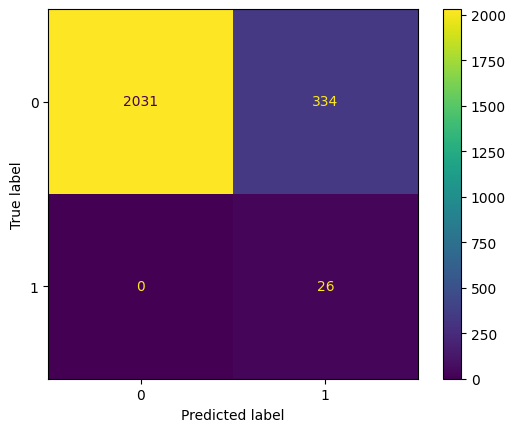

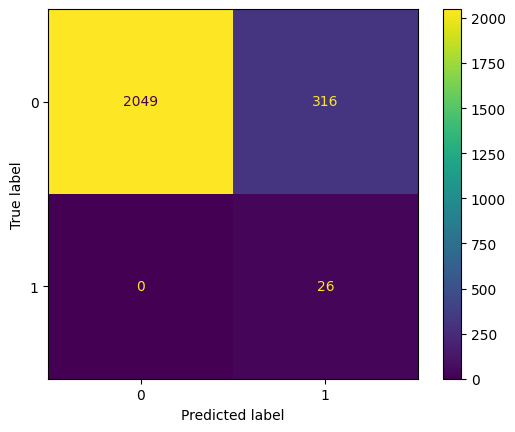

In [7]:

#set variables -------------------------------------------------------------------------------------------------------------------------------------------------------------------#

#path dataset
separator = ','
url_data = 'data/sharp_abcmx-nf-all_6h_2010-01-01_2024-04-30.csv'

#Coluns Delete in CSV file
#list_col_delete = ['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','OBS_VR', 'QUALITY', 'Class_Flare']

#Attributes' redution 
list_col_delete = ['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','OBS_VR', 'QUALITY', 'Class_Flare', 'MEANGAM','MEANGBT','MEANGBZ','MEANSHR','MEANGBH','MEANJZH', 'MEANJZD','MEANALP'] 

date_chronological_empty = []
#date_chronological = ["2010-01-01 00:00:00", "2014-10-26 23:59:00", "2014-10-27 00:00:00", "2015-10-30 23:59:00", "2015-10-31 00:00:00", "2023-12-31 23:59:00"]

#date A1 - 2010-2011
date_chronological_A1 = ["2010-05-03 00:00:00", "2010-10-31 23:59:59", "2011-06-01 00:00:00", "2011-12-31 23:59:59", "2010-11-01 00:00:00", "2011-01-31 23:59:59", "2011-02-21 00:00:00", "2011-05-31 23:59:59"]

#date A2 - 2012 - 2013
date_chronological_A2 = ["2012-01-01 00:00:00", "2012-08-31 23:59:59", "2013-07-01 00:00:00", "2014-08-31 23:59:59", "2012-09-01 00:00:00", "2013-01-31 23:59:59", "2013-02-01 00:00:00", "2013-06-30 23:59:59"]

#date A3  - 2014-2016
date_chronological_A3 = ["2014-09-01 00:00:00", "2015-03-31 23:59:59", "2015-10-01 00:00:00", "2016-06-30 23:59:59", "2015-04-01 00:00:00", "2015-06-30 23:59:59", "2015-07-01 00:00:00", "2015-09-30 23:59:59"]

#date A4 - 2016-2018
date_chronological_A4 = ["2016-07-01 00:00:00", "2017-02-28 23:59:59", "2017-09-01 00:00:00", "2018-07-31 23:59:59", "2017-03-01 00:00:00", "2017-05-31 23:59:59", "2017-06-01 00:00:00", "2017-08-31 23:59:59"]

#set parameters before training
set_dataset_base = "all-abcmx"
set_window = "24h"
set_epoch  = 10
set_batch = 64
set_model_name = ['transformers'] # ['mlp', 'svm','lstm','transformers']
set_dataset_base = ['A1'] #['all', 'A1', 'A2', 'A3', 'A4']
set_balancing = ['weight', 'oversampling'] # ['weight', 'undersampling', 'oversampling', 'smote']

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

#config datetime format    
#custom_date_parser = lambda x: datetime.strptime(x, "%Y.%m.%d_%H:%M:%S_TAI") 
custom_date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') 
 
#load csv 
raw_df = pd.read_csv(url_data, sep=',')
raw_df['T_REC'] = pd.to_datetime(raw_df['T_REC'], format='%Y-%m-%d %H:%M:%S')
raw_df.sort_values(by='T_REC')

#drop nan values
print("Lenght before drop nan values: ", len(raw_df))
raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_df.dropna(subset=raw_df.columns, inplace=True)
raw_df.drop
print("Lenght after drop nan values: ", len(raw_df))


#convert pandas' dataset to dask dataframe
cleaned_df = dd.from_pandas(raw_df, npartitions=10)

#delete unused columns
for lcd in list_col_delete:
    cleaned_df.pop(lcd)

#count row class
neg = len(cleaned_df [cleaned_df.Class == 0])
pos = len(cleaned_df [cleaned_df.Class == 1])


#training models
for smn in set_model_name:

    for sdb in set_dataset_base:

        for sba in set_balancing:
            print(sdb, ' - ', set_window,  ' - ', set_batch,  ' - ', set_epoch, ' - ', smn,  ' - ', sba,  ' - ')
            if sdb == 'all':
                execute_all_models(sdb, set_window, set_batch, set_epoch, cleaned_df, smn, sba, "random", date_chronological_empty)
            elif sdb == 'A1':
                execute_all_models(sdb, set_window, set_batch, set_epoch, cleaned_df, smn, sba, "chronological", date_chronological_A1)
            elif sdb == 'A2':
                execute_all_models(sdb, set_window, set_batch, set_epoch, cleaned_df, smn, sba, "chronological", date_chronological_A2)
            elif sdb == 'A3':
                execute_all_models(sdb, set_window, set_batch, set_epoch, cleaned_df, smn, sba, "chronological", date_chronological_A3)
            elif sdb == 'A4':
                execute_all_models(sdb, set_window, set_batch, set_epoch, cleaned_df, smn, sba, "chronological",  date_chronological_A4)
            
